kaggle 데이터를 사용하여 만든 이진 분류 모델

데이터를 non+very mild / mild+moderate demented 두가지 그룹으로 묶어서 진행

- non (488) + very mild(488) -> 0

- mild (488) + moderate (488) -> 1 로 인코딩

## 0. Import Library

In [2]:
!pip install tqdm
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [3]:
import os 
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Recall

from keras.models import Sequential, load_model
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import tensorflow as tf

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Data

In [4]:
# 경로 설정
data_dir = "../kaggle/"

# 이미지 리스트 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# 카테고리 리스트 및 경로 초기화
path_list = ["Mild Dementia", "Moderate Dementia", 
             "Non Demented", "Very mild Dementia"]

In [5]:
# 카테고리 별 이미지 경로 저장을 위한 딕셔너리 초기화
image_paths = {
    "Mild Dementia": [],
    "Moderate Dementia": [],
    "Non Demented": [],
    "Very mild Dementia": []
}

# 각 카테고리 별 경로 추가
for category in path_list:
    category_dir = os.path.join(data_dir, category)
    for dirname, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_paths[category].append(os.path.join(dirname, filename))

# 확인
for category in path_list:
    print(f'{category}: {len(image_paths[category])} images')

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13725 images


In [6]:
# 각 카테고리별 파일 경로 리스트
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

images, labels = [], []

In [7]:
# 각 카테고리 폴더 내 파일 경로를 리스트에 추가
for category in tqdm(path_list):
    category_dir = os.path.join(data_dir, category)
    for root, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_path = os.path.join(root, filename)
            images.append(image_path)
            labels.append(category)
            if category == "Non Demented":
                non_demented.append(image_path)
            elif category == "Very mild Dementia":
                very_mild_demented.append(image_path)
            elif category == "Mild Dementia":
                mild_demented.append(image_path)
            elif category == "Moderate Dementia":
                moderate_demented.append(image_path)

100%|██████████| 4/4 [00:00<00:00, 33.64it/s]


In [8]:
# 이미지 경로와 레이블을 포함하는 DataFrame 생성
df = pd.DataFrame({'image': images, 'label': labels})
df.head() 

,image,label
0,../kaggle/Mild Dementia/OAS1_0137_MR1_mpr-3_13...,Mild Dementia
1,../kaggle/Mild Dementia/OAS1_0291_MR1_mpr-3_10...,Mild Dementia
2,../kaggle/Mild Dementia/OAS1_0278_MR1_mpr-2_11...,Mild Dementia
3,../kaggle/Mild Dementia/OAS1_0382_MR1_mpr-4_12...,Mild Dementia
4,../kaggle/Mild Dementia/OAS1_0316_MR1_mpr-1_14...,Mild Dementia


In [9]:
# 이미지 경로 저장
df.to_csv('../gradcam/kaggle_image_labels.csv', index=False)

/var/folders/s1/nf_zq41n2nd447kv5d44gx2h0000gn/T/ipykernel_98979/1748014159.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set1')


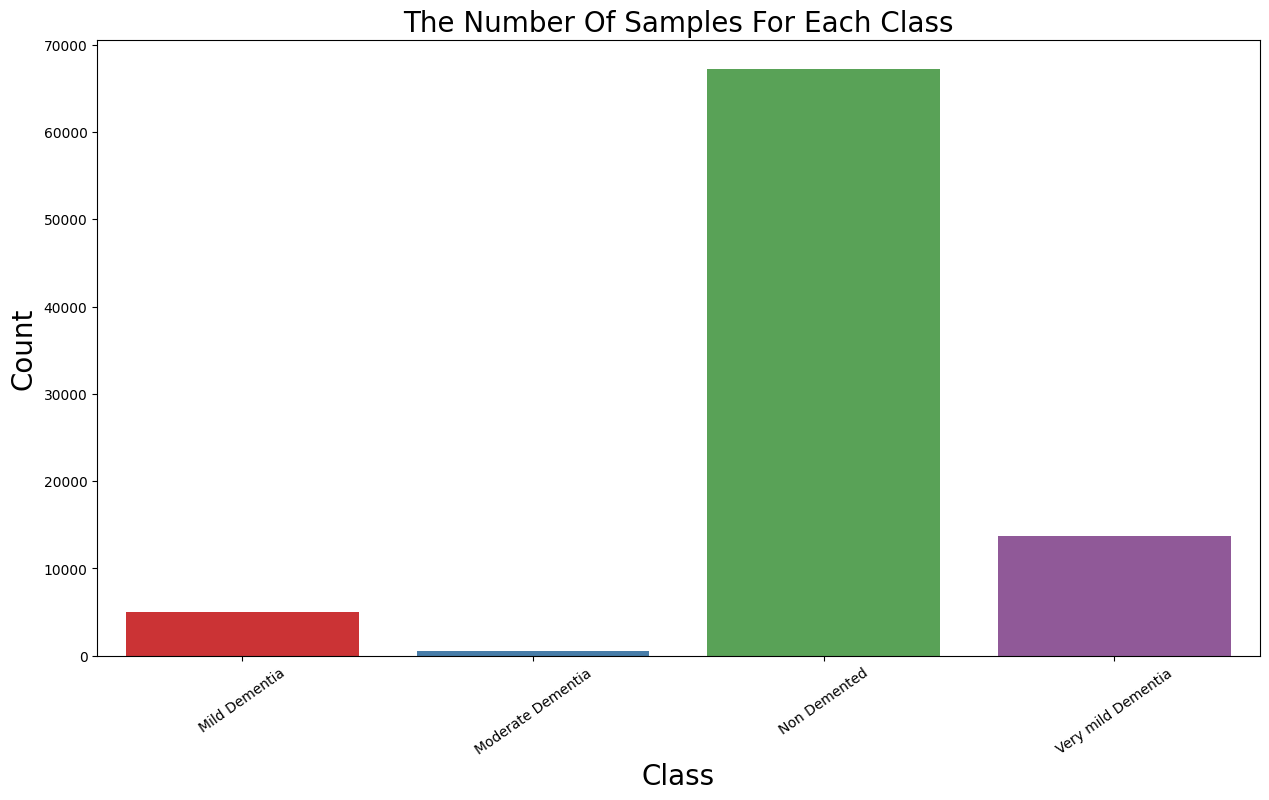

In [10]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

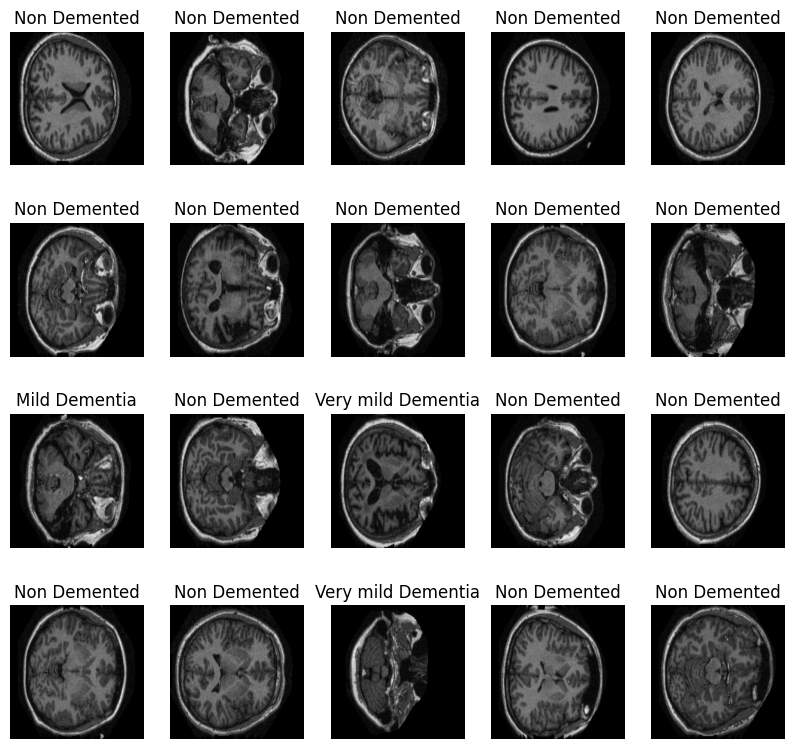

In [11]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

## 2. Preprocessing

In [12]:
data = []
result = []

### 1) Label Encoding

In [13]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [14]:
# 각 리스트에서 이미지를 읽어와 데이터와 결과에 추가하는 함수
def load_images(category_list, label):
    for image_path in category_list:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img = np.array(img)
        data.append(img)
        result.append(encoder.transform([[label]]).toarray())

In [15]:
# 각 카테고리별로 이미지 로드
load_images(non_demented, 0)
load_images(very_mild_demented, 1)
load_images(mild_demented, 2)
load_images(moderate_demented, 3)

In [16]:
# 결과 데이터 변환 확인
data = np.array(data)
result = np.array(result).reshape(len(result), -1)
print(f"Data shape: {data.shape}, Result shape: {result.shape}")

Data shape: (86437, 128, 128, 3), Result shape: (86437, 4)


### 2) Reshape data

In [17]:
X=np.array(data)
y=np.array(result)

y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)

### 3) Balance data

In [32]:
# 그룹별 인덱스 추출
non_indices = np.where(y == 0)[0]          # non_demented
very_mild_indices = np.where(y == 1)[0]    # very_mild_demented
mild_indices = np.where(y == 2)[0]         # mild_demented
moderate_indices = np.where(y == 3)[0]     # moderate_demented

# 각 그룹에서 샘플 추출
np.random.seed(42)  

# non_demented + very_mild_demented (0) 그룹에서 각각 488개씩 추출 (총 976개)
non_very_mild_sample_indices = np.random.choice(np.concatenate([non_indices, very_mild_indices]), 976, replace=False)

# moderate_demented + mild_demented (1) 그룹에서 각각 488개씩 추출 (총 976개)
moderate_mild_sample_indices = np.random.choice(np.concatenate([moderate_indices, mild_indices]), 976, replace=False)

# 인덱스 결합
group_0_indices = non_very_mild_sample_indices  
group_1_indices = moderate_mild_sample_indices  

# X와 y 데이터 추출
X_balanced = np.concatenate([X[group_0_indices], X[group_1_indices]])
y_balanced = np.concatenate([np.zeros(len(group_0_indices)), np.ones(len(group_1_indices))])

print("Balanced X shape:", X_balanced.shape)
print("Balanced y distribution:", np.bincount(y_balanced.astype(int)))

Balanced X shape: (1952, 128, 128, 3)
Balanced y distribution: [976 976]


### 3) Split data

In [33]:
X_train, X_test, y_train, y_test= train_test_split(X_balanced, y_balanced,test_size=0.2,random_state=42, shuffle = True)
print("X train shape: ", X_train.shape)
print("Ytrain shape: ", y_train.shape)

X train shape:  (1561, 128, 128, 3)
Ytrain shape:  (1561,)


## 3. Modeling

In [34]:
# CNN 모델 생성
def create_compile_model():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,3)))

    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation='sigmoid'))

    print(model.summary())

    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                   metrics=['accuracy',         
                           'Precision',       
                           'Recall',           
                           AUC()])             
    
    
    return model

In [36]:
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

checkpoint = ModelCheckpoint(
    filepath='../model/binary_model1109.keras',  
    monitor='val_loss',       
    save_best_only=True,       
    mode='min',               
    verbose=1               
)

## 4. Training

In [37]:
model = create_compile_model()

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,517,825 (32.49 MB)

 Trainable params: 8,517,377 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [38]:
history= model.fit(X_train,
                   y_train,
                   validation_split=0.2,
                   epochs=100,
                   callbacks=[early_stopping, checkpoint],
                   batch_size=32)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - Precision: 0.5880 - Recall: 0.5720 - accuracy: 0.5844 - auc_1: 0.5994 - loss: 5.0885
Epoch 1: val_loss improved from inf to 2.73005, saving model to ../model/binary_model1109.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 400ms/step - Precision: 0.5890 - Recall: 0.5735 - accuracy: 0.5857 - auc_1: 0.6009 - loss: 5.0282 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4665 - val_auc_1: 0.6604 - val_loss: 2.7300
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - Precision: 0.7168 - Recall: 0.7042 - accuracy: 0.7102 - auc_1: 0.7999 - loss: 0.6427
Epoch 2: val_loss improved from 2.73005 to 0.94679, saving model to ../model/binary_model1109.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step - Precision: 0.7172 - Recall: 0.7053 - accuracy: 0.7109 - auc_1: 0.8005 - loss: 0.6414 - val_Precision: 0.8571 - val_Recall: 0.0719 - val_accuracy: 0.4984 - val_auc_1: 0.7748 - val_loss: 0.9468
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 36

## Evaluation

### 1. Accuracy

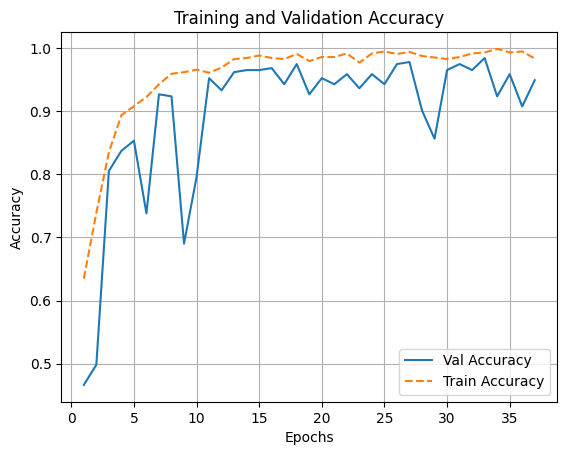

In [44]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy,  label=f'Val Accuracy')
plt.plot(epochs, train_accuracy, linestyle='--', label=f'Train Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### 2. Precision

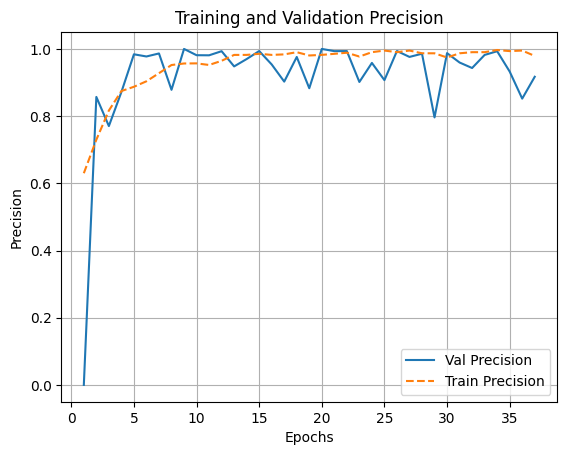

In [45]:
val_precision = history.history['val_Precision']
train_precision = history.history['Precision']
epochs = range(1, len(val_precision) + 1)

plt.plot(epochs, val_precision, label='Val Precision')
plt.plot(epochs, train_precision, linestyle='--', label='Train Precision')

plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

### 3. Recall

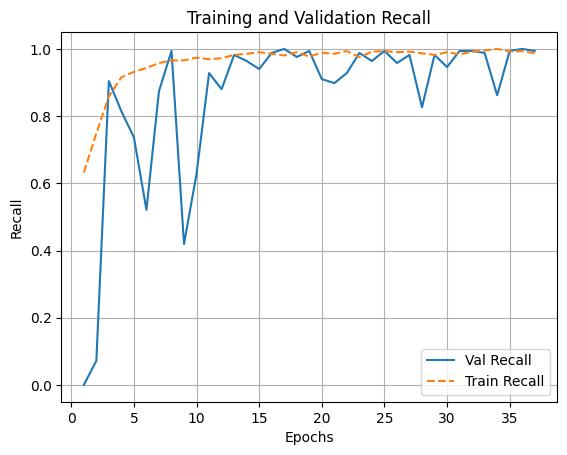

In [46]:
val_recall = history.history['val_Recall']
train_recall = history.history['Recall']
epochs = range(1, len(val_recall) + 1)

plt.plot(epochs, val_recall, label='Val Recall')
plt.plot(epochs, train_recall, linestyle='--', label='Train Recall')

plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

### 4. AUC

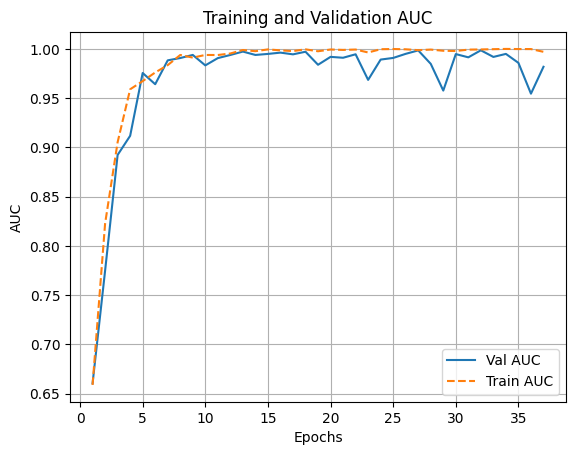

In [47]:
val_auc = history.history['val_auc_1']
train_auc = history.history['auc_1']
epochs = range(1, len(val_auc) + 1)

plt.plot(epochs, val_auc, label='Val AUC')
plt.plot(epochs, train_auc, linestyle='--', label='Train AUC')

plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()

### 5. Confusion Matrix

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


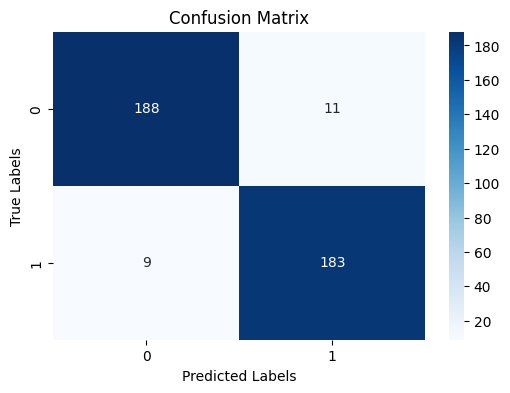

In [48]:
y_pred = model.predict(X_test)
y_pred = (model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()